In [1]:
%load_ext autoreload
%autoreload 2

Before running this notebook, download the data folder from the Github repository for fairmlbook (Barocas, Hardt and Narayanan 2018): github.com/fairmlbook/fairmlbook.github.io/tree/master/code/creditscore/data, then update `DATA_DIR`.

In [6]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import fico

DATA_DIR = '../data/fico/'
save_fig=True

Populating the interactive namespace from numpy and matplotlib


In [7]:
# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

# 0. Load and parse data

In [8]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);

   Asian   White  Hispanic  Black
0   7906  133165     14702  18274


In [9]:
group_ratio = np.array((totals["Black"], totals["White"]))
group_size_ratio = group_ratio/group_ratio.sum()
print(group_size_ratio)

utility_repaid = 1
utility_default = -4 # -4

[0.12066905 0.87933095]


In [10]:
cdfs = all_cdfs[["White","Black"]]

cdf_B = cdfs['White'].values
cdf_A = cdfs['Black'].values

repay_B = performance['White'].values
repay_A = performance['Black'].values


def get_pmf(cdf):
    pis = np.zeros(cdf.size)
    pis[0] = cdf[0]
    for score in range(cdf.size-1):
        pis[score+1] = cdf[score+1] - cdf[score]
    return pis

def get_cdf(pmf):
    cdf = np.zeros(pmf.size)
    cdf[0] = pmf[0]
    for score in range(1,cdf.size):
        cdf[score] = pmf[score] + cdf[score-1]
    return cdf

pmf_A = get_pmf(cdf_A)
pmf_B = get_pmf(cdf_B)


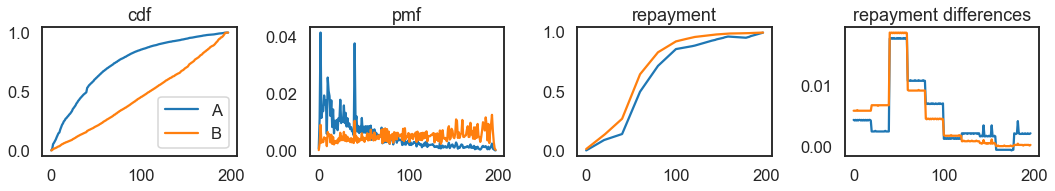

In [11]:
plt.figure(figsize=[15,3])
plt.subplot(1,4,1)
plt.title('cdf')
plt.plot(cdf_A,label='A')
plt.plot(cdf_B,label='B')
plt.legend()

plt.subplot(1,4,2)
plt.title('pmf')
plt.plot(pmf_A,label='A')
plt.plot(pmf_B,label='B')

plt.subplot(1,4,3)
plt.title('repayment')
plt.plot(repay_A,label='A')
plt.plot(repay_B,label='B')

plt.subplot(1,4,4)
plt.title('repayment differences')
plt.plot((repay_A[1:] - repay_A[:-1]))
plt.plot((repay_B[1:] - repay_B[:-1]))

plt.tight_layout()

# 1. Transforming into profit scores and interpolating

In [12]:
## reordering scores / pmfs by repayment

reordered_inds_A = np.argsort(repay_A)
reordered_inds_B = np.argsort(repay_B)

repay_A = repay_A[reordered_inds_A]
repay_B = repay_B[reordered_inds_B]

pmf_A = pmf_A[reordered_inds_A]
pmf_B = pmf_B[reordered_inds_B]

cdf_A = get_cdf(pmf_A)
cdf_B = get_cdf(pmf_B)


In [13]:
## interpolating to make denser

repay_A_orig = repay_A
repay_B_orig = repay_B

pmf_A_orig = pmf_A
pmf_B_orig = pmf_B

def interpolate(values):
    new_values = np.zeros(2 * len(values))
    new_values[1::2] = values
    new_values[::2] = (np.hstack([0,values[:-1]]) + values) / 2
    return new_values

print(repay_A.shape)
# 8x denser via linear interpolation
for i in [0,1,2]:
    repay_A = interpolate(repay_A)
    repay_B = interpolate(repay_B)

    cdf_A = interpolate(cdf_A)
    cdf_B = interpolate(cdf_B)

    pmf_A = get_pmf(cdf_A)
    pmf_B = get_pmf(cdf_B)
print(repay_A.shape)

(198,)
(1584,)


In [14]:
## Defining profit scores


prof_score_A = (utility_repaid - utility_default) * repay_A + utility_default
prof_score_A_orig = (utility_repaid - utility_default) * repay_A_orig + utility_default

prof_score_B = (utility_repaid - utility_default) * repay_B + utility_default
prof_score_B_orig = (utility_repaid - utility_default) * repay_B_orig + utility_default

# 2. Optimizing via Gridding

In [15]:
## Gridding over all thresholds

Up_by_thresh = {'tA':[], 'tB':[], 'Up':[], 'bA':[], 'bB':[]}
for thresh_A in np.hstack([-4,prof_score_A,1]):
    for thresh_B in np.hstack([-4,prof_score_B,1]):
        selected_A = prof_score_A >= thresh_A
        selected_B = prof_score_B >= thresh_B
        
        Up_by_thresh['bA'].append(np.sum(pmf_A[selected_A]))
        Up_by_thresh['bB'].append(np.sum(pmf_B[selected_B]))
        
        U_p = (np.sum(group_size_ratio[0] * pmf_A[selected_A] * prof_score_A[selected_A]) 
               + np.sum(group_size_ratio[1] * pmf_B[selected_B] * prof_score_B[selected_B]))
        Up_by_thresh['tA'].append(thresh_A)
        Up_by_thresh['tB'].append(thresh_B)
        Up_by_thresh['Up'].append(U_p)

for key in Up_by_thresh.keys():
    Up_by_thresh[key] = np.array(Up_by_thresh[key])

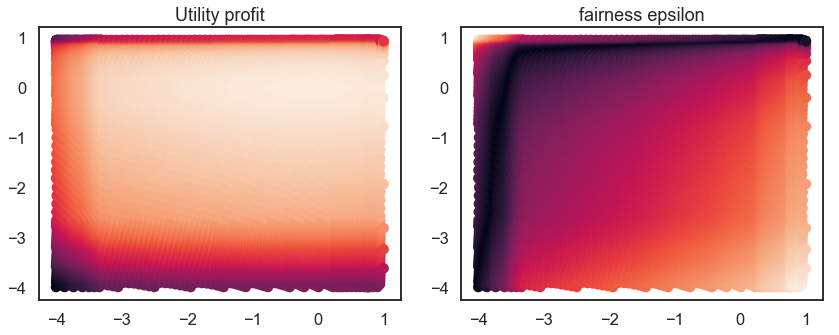

In [16]:
fig, ax = plt.subplots(1,2,figsize=(12,5)); 

im = ax[0].scatter(Up_by_thresh['tA'][::100], Up_by_thresh['tB'][::100], c=Up_by_thresh['Up'][::100])
ax[0].set_title('Utility profit')

eps_f = np.abs(np.array(Up_by_thresh['bA'])-np.array(Up_by_thresh['bB']))
im = ax[1].scatter(Up_by_thresh['tA'][::100], Up_by_thresh['tB'][::100], c=eps_f[::100])
ax[1].set_title('fairness epsilon')

plt.tight_layout()

In [17]:
## Determining thresholds for each value of epsilon

eps_policies = {'eps':[], 'Up':[], 'tA':[], 'tB':[]}
prev_valid = eps_f < -1
eps_sample = 5000; eps_min = 0.002; eps_max = 0.55
eps_list = np.unique(eps_f)[eps_sample::eps_sample]
eps_list = eps_list[(eps_list > eps_min) * (eps_list < eps_max)]
for eps in eps_list:
    valid_choices = eps_f < eps
    # check that decision space increases with each increasing epsilon
    assert sum(prev_valid * (1-valid_choices)) == 0, sum(prev_valid * (1-valid_choices))
    max_util = np.max(valid_choices * np.array(Up_by_thresh['Up']))
    # check that the maximum is positive
    assert max_util > 0, max_util
    argmax_util = (valid_choices * np.array(Up_by_thresh['Up']))==max_util
    
    eps_policies['eps'].append(eps)
    eps_policies['Up'].append(max_util)
    eps_policies['tA'].append(np.mean(Up_by_thresh['tA'][argmax_util]))
    if sum(argmax_util) > 1 and len(eps_policies['tB']) > 1:
        print(sum(argmax_util),Up_by_thresh['tB'][argmax_util],argmax_util)
        arg_close = np.argmin(Up_by_thresh['tB'][argmax_util] - eps_policies['tB'][-1])
        tB = Up_by_thresh['tB'][argmax_util][arg_close]
    else:
        tB = np.max(Up_by_thresh['tB'][argmax_util])
    eps_policies['tB'].append(tB)


# 3. Converting thresholds to welfare scores

In [18]:
## Defining welfare scores

def get_tB_of_p(p):
    ind = np.argmin(np.abs(np.array(eps_policies['tA'])-p))
    return eps_policies['tB'][ind]

welf_score_A = []
for p in prof_score_A_orig:
    if p < np.min(eps_policies['tA']):
        w = 0. # np.min(eps_policies['tA'])
    elif p > np.max(eps_policies['tA']):
        w = 0. #np.max(eps_policies['tA'])
    else:
        num = p
        w = -1 * num / get_tB_of_p(p)
    welf_score_A.append(w)
    
    
welf_score_B = []
for p in prof_score_B_orig:
    if p < 0:
        w = -0.
    elif p > np.max(eps_policies['tB']):
        w = -0.
    else:
        w = -1
    welf_score_B.append(w)
    

In [19]:
## Computing pareto policies directly from scores

combined_prof = np.hstack([prof_score_A_orig, prof_score_B_orig])
combined_welf = np.hstack([welf_score_A, welf_score_B])
combined_pmf = np.hstack([group_size_ratio[0] * pmf_A_orig, group_size_ratio[1] * pmf_B_orig])

util_w = []
util_p = []
alphas_pareto = linspace(0,.7,100)
for alpha in alphas_pareto:
    alpha_score = (1-alpha) * combined_prof + alpha * combined_welf
    util_w.append(np.sum(combined_pmf[alpha_score>0] * combined_welf[alpha_score>0]))
    util_p.append(np.sum(combined_pmf[alpha_score>0] * combined_prof[alpha_score>0]))




In [20]:
save_fig = False

# 4. Plotting Results

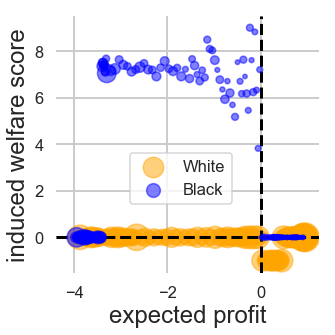

In [21]:
sns.set_context('talk')

fig, ax = plt.subplots(1,figsize=(5,5))

dot_scale = 0.5

ax.scatter(prof_score_B_orig, welf_score_B, 
              s=dot_scale*group_ratio[1]*pmf_B_orig, 
              alpha=0.5, 
              color='orange',
              label='White',
             
           )
ax.scatter(prof_score_A_orig, welf_score_A, 
              s=dot_scale*group_ratio[0]*pmf_A_orig, 
              alpha=0.5, 
              color='blue',
              label='Black',
              zorder=3,
           )

ax.legend(bbox_to_anchor=(0.7,0.5))
         #prop={'size': 16})

ax.grid(lw=2)
ax.set_xlabel('expected profit', fontsize=24)
ax.set_ylabel('induced welfare score', fontsize=24)

sns.despine()

# replace axes lines on left subplot with lines at 0 and 1
sns.despine(ax=ax, left=True, bottom=True)

ax.axhline(0,zorder=2, color='black', lw=3, ls= '--')
ax.axvline(0,zorder=2, color='black', lw=3, ls= '--')
plt.tight_layout()

if save_fig:
    plt.savefig("../icml/figures/fairness_induced_weights.pdf",bbox_inches='tight')

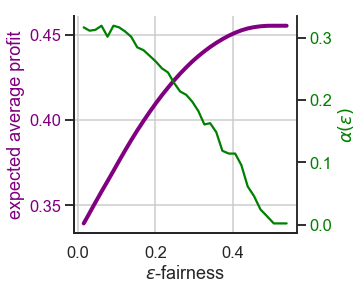

In [22]:
fig, ax= plt.subplots(1, figsize=(4,4))

ax.plot(eps_policies['eps'], eps_policies['Up'], lw =4, color='purple')

ax.grid()
ax.set_xlabel(r'$\epsilon$-fairness')
ax.set_ylabel('expected average profit', color='purple')
ax.tick_params(axis='y', labelcolor='purple')
ax.set_yticks([0.35,0.40,0.45])

axis_alpha = ax.twinx()
alphas_eps = np.array(eps_policies['tB']) / (np.array(eps_policies['tB']) + 1)
axis_alpha.plot( eps_policies['eps'],alphas_eps, color='green')
#axis_alpha.set_xlabel(r'corresponding $\epsilon$'); 
axis_alpha.set_ylabel(r'$\alpha (\epsilon)$', color='green')
axis_alpha.tick_params(axis='y', labelcolor='green')

sns.despine(ax=ax,right=False, top=True)
sns.despine(ax=axis_alpha,top=True)

if save_fig:
    plt.savefig("../icml/figures/fairness_alpha_epsilon.pdf",bbox_inches='tight')

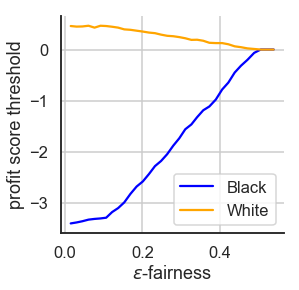

In [23]:
fig, ax= plt.subplots(1, figsize=(4,4))


ax.plot(eps_policies['eps'], eps_policies['tA'], label='Black', color='blue')
ax.plot(eps_policies['eps'], eps_policies['tB'], label='White', color='orange')

ax.legend(); 
ax.set_xlabel(r'$\epsilon$-fairness')
ax.set_ylabel('profit score threshold');
ax.grid()

sns.despine()

if save_fig:
    plt.savefig("../../icml/figures/fairness_epsilon_thresh.pdf",bbox_inches='tight')

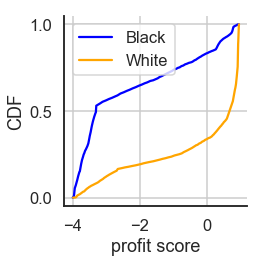

In [24]:
# plot the repay probabilities
fig, ax = plt.subplots(1,figsize=(4,4)); 

ax.plot(prof_score_A,cdf_A,color='blue',label='Black')
ax.plot(prof_score_B,cdf_B,label='White',color="orange")
# ax.set_title("profit score")
ax.set_ylabel("CDF")
ax.set_xlabel("profit score")
ax.legend()
ax.grid()
ax.set_yticks([0,0.5,1])

sns.despine()


plt.tight_layout()

if save_fig:
    plt.savefig("../../icml/figures/fairness_cdf_p.pdf",bbox_inches='tight')